# AMES HOUSING - Advanced Regression Techniques

## 0) Notebook Dependencies

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error


## 1) Business Understanding

### 1.1 Problem Context

Accurately pricing residential homes is a core challenge in real estate. Prices depend on a mix of structural attributes (size, quality, age), location characteristics (neighborhood, lot shape, frontage), and amenity-related features (garages, basements, fireplaces, pools, etc.). Mispricing can lead to financial loss, poor negotiation outcomes, or inefficient decision-making.

The House Prices: Advanced Regression Techniques competition aims to build a predictive model that uses 79 explanatory variables describing homes in Ames, Iowa, to estimate their final sale price. The problem mirrors real-world valuation tasks and offers a rich environment for regression modeling and feature engineering.


### 1.2 Why This Problem Matters

Home valuation is foundational to multiple stakeholders:

- Buyers & Sellers — need realistic expectations of a property's market value.

- Real-estate agents & platforms — rely on accurate automated valuation tools to assist pricing, recommendations, and risk evaluation.

- Financial institutions — use property valuations in lending decisions and investment analysis.

- Data science teams — leverage this type of problem to refine modeling workflows, feature engineering strategies, and handling of messy mixed-type data.

A strong predictive model reduces uncertainty, speeds up assessments, and creates a scalable, data-driven alternative to purely manual appraisal approaches.



### 1.3 Prediction Target

The task is to predict `SalePrice`, the final price of a house.
Performance is measured using _Root Mean Squared Error (RMSE) on the log-transformed sale prices_. This rewards models that minimize relative errors, keeping both inexpensive and expensive homes equally weighted in terms of prediction quality.

### 1.4 Business Questions

* Key questions driving the modeling effort include:

* Which features most strongly influence a home's market value?

* How can missing values, categorical variables, and skewed numeric distributions be handled effectively?

* Can the model generalize well to unseen homes without overfitting?

* Can the completed workflow support an automated valuation system for practical real-estate use cases?






### 1.5 Constraints & Considerations

* The dataset is based on homes from Ames, Iowa, meaning learned relationships may not transfer perfectly to other housing markets.

* Several features contain missing values, requiring thoughtful imputation strategies.

* Many predictors are categorical or ordinal, requiring proper encoding.

* Some numeric features are skewed, making transformations beneficial.

* The evaluation metric emphasizes proportional accuracy, not absolute dollar error.


## 2) Business Objectives & Success Criteria

### 2.1 Business Objectives

The goal of this project is to build a reliable and interpretable house-price prediction model that can:

- Estimate a home’s market value based on its characteristics.

- Support automated pricing workflows used by real-estate platforms or decision-makers.

- Identify key drivers of price to aid in market analysis.

- Deliver stable predictions that generalize well to unseen properties.




### 2.2 Success Criteria

**Business Success Criteria**

* Predictions should be accurate enough to be practically useful for valuation and pricing support.

* Important features should align with real-estate intuition and provide actionable insight.

* The model should reduce pricing uncertainty compared to naive or baseline approaches.

**Technical Success Criteria**

* Achieve a strong log-RMSE score relative to baseline models and competition benchmarks.

* Demonstrate effective preprocessing: imputation, encoding, outlier handling, and feature selection.

* Avoid overfitting by validating performance through cross-validation or holdout strategies.

* Produce a reproducible modeling pipeline aligned with CRISP-DM principles.

## 3) Data Understanding

### Load data & basic info
Read train/test, split numeric vs categorical columns, and preview the data.


In [27]:
from pathlib import Path

pd.set_option('display.max_columns', 90)
pd.set_option('display.width', 120)

DATA_DIR = Path('data')
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

target = 'SalePrice'
id_col = 'Id'

num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col != target]
cat_cols = [col for col in train_df.columns if col not in num_cols + [target]]

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
display(train_df.head(3))
display(train_df.describe(include='all').T[['count', 'mean', 'std', 'min', 'max']].head(10))


Train shape: (1460, 81), Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


,count,mean,std,min,max
Id,1460.0,730.5,421.610009,1.0,1460.0
MSSubClass,1460.0,56.89726,42.300571,20.0,190.0
MSZoning,1460,NaN,NaN,NaN,NaN
LotFrontage,1201.0,70.049958,24.284752,21.0,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,215245.0
Street,1460,NaN,NaN,NaN,NaN
Alley,91,NaN,NaN,NaN,NaN
LotShape,1460,NaN,NaN,NaN,NaN
LandContour,1460,NaN,NaN,NaN,NaN
Utilities,1460,NaN,NaN,NaN,NaN


### Missingness patterns
Quantify missingness and check how missing flags correlate with SalePrice.


Features with missing values: 19


,feature,pct_missing
0,PoolQC,99.520548
1,MiscFeature,96.301370
2,Alley,93.767123
3,Fence,80.753425
4,MasVnrType,59.726027
5,FireplaceQu,47.260274
6,LotFrontage,17.739726
7,GarageQual,5.547945
8,GarageFinish,5.547945
9,GarageType,5.547945


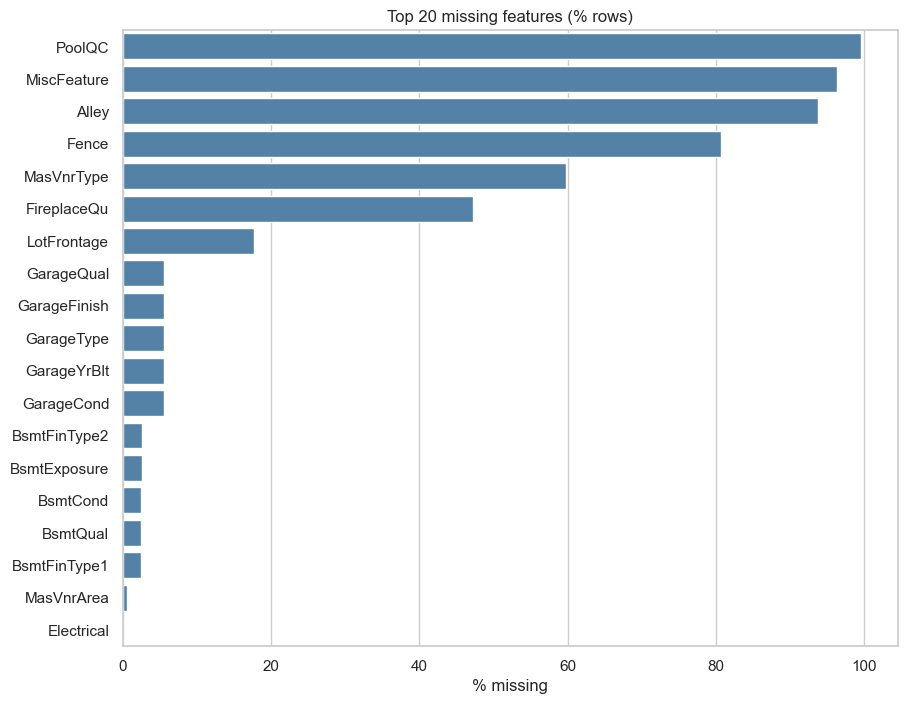

Missingness correlation with SalePrice (top 10):


,corr_with_target
Fence_na,0.172184
Alley_na,0.123611
MiscFeature_na,0.072298
MasVnrArea_na,0.051933
LotFrontage_na,0.004087
Electrical_na,-0.004424
PoolQC_na,-0.093708
BsmtFinType2_na,-0.145274
BsmtExposure_na,-0.150231
BsmtCond_na,-0.152829


In [28]:
missing_pct = train_df.isna().mean().sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
missing_df = missing_pct.mul(100).reset_index()
missing_df.columns = ['feature', 'pct_missing']

print(f"Features with missing values: {missing_df.shape[0]}")
display(missing_df.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=missing_df.head(20), x='pct_missing', y='feature', color='steelblue')
plt.title('Top 20 missing features (% rows)')
plt.xlabel('% missing')
plt.ylabel('')
plt.show()

if not missing_df.empty:
    missing_flags = {f"{col}_na": train_df[col].isna().astype(int) for col in missing_df['feature']}
    miss_corr = pd.DataFrame(missing_flags).corrwith(train_df[target]).sort_values(ascending=False)
    print('Missingness correlation with SalePrice (top 10):')
    display(miss_corr.head(10).to_frame('corr_with_target'))


### SalePrice distribution & outlier scan
Inspect the target distribution in linear/log space and list IQR-based outliers.


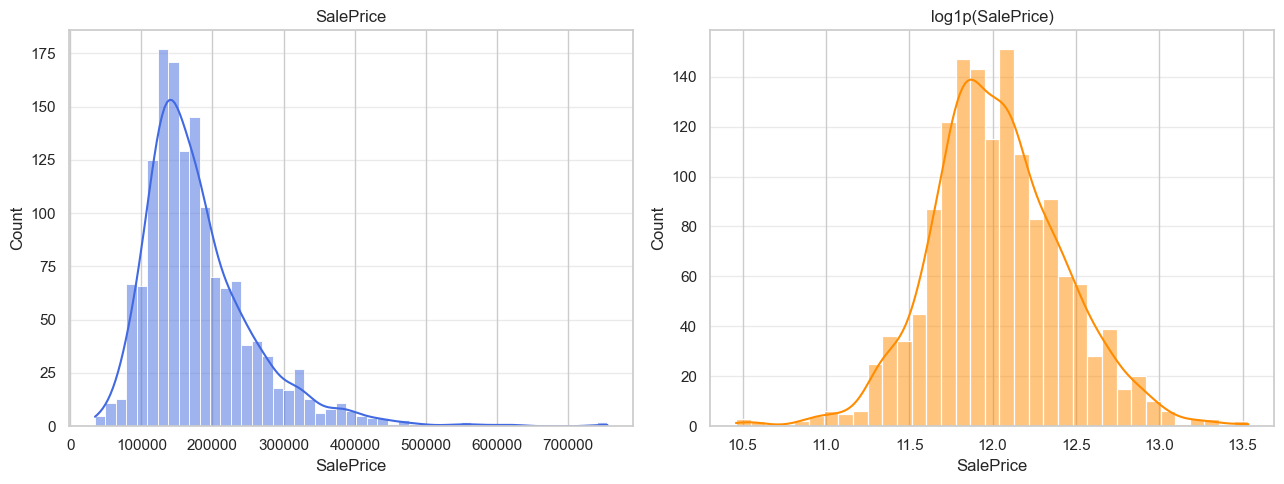

Outlier count (IQR rule): 61


,Id,SalePrice,GrLivArea,OverallQual,Neighborhood
691,692,755000,4316,10,NoRidge
1182,1183,745000,4476,10,NoRidge
1169,1170,625000,3627,10,NoRidge
898,899,611657,2364,9,NridgHt
803,804,582933,2822,9,NridgHt
1046,1047,556581,2868,9,StoneBr
440,441,555000,2402,10,NridgHt
769,770,538000,3279,8,StoneBr
178,179,501837,2234,9,StoneBr
798,799,485000,3140,9,NridgHt


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.histplot(train_df[target], kde=True, ax=axes[0], color='royalblue')
axes[0].set_title('SalePrice')

sns.histplot(np.log1p(train_df[target]), kde=True, ax=axes[1], color='darkorange')
axes[1].set_title('log1p(SalePrice)')
for ax in axes:
    ax.grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

q1, q3 = train_df[target].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outlier_mask = (train_df[target] < lower) | (train_df[target] > upper)
outliers = train_df.loc[outlier_mask, ['Id', target, 'GrLivArea', 'OverallQual', 'Neighborhood']]
print(f"Outlier count (IQR rule): {outliers.shape[0]}")
display(outliers.sort_values(target, ascending=False).head(10))


### Numeric features vs SalePrice
Check strongest numeric correlations and key scatter/regression plots.


Top numeric correlations with SalePrice:


,corr
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


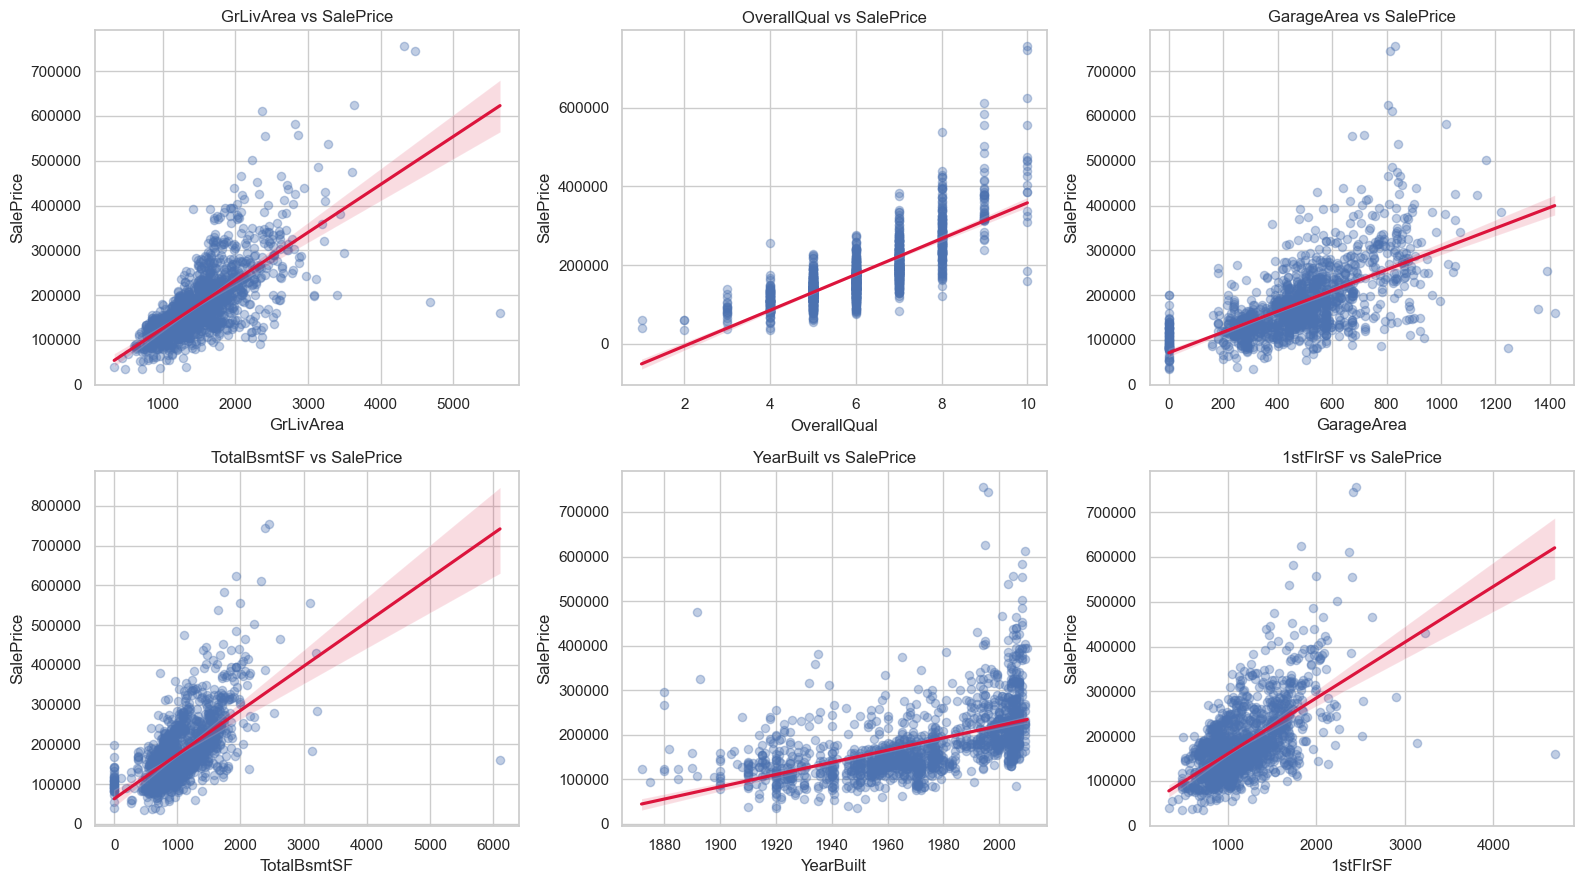

In [30]:
corr_with_target = train_df[num_cols + [target]].corr()[target].drop(target).sort_values(ascending=False)
top_numeric = corr_with_target.head(10)
print('Top numeric correlations with SalePrice:')
display(top_numeric.to_frame('corr'))

feature_list = ['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF']
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for ax, feature in zip(axes.flat, feature_list):
    sns.regplot(data=train_df, x=feature, y=target, ax=ax,
                scatter_kws={'alpha': 0.35, 's': 35}, line_kws={'color': 'crimson'})
    ax.set_title(f"{feature} vs SalePrice")
plt.tight_layout()
plt.show()


### Categorical features vs SalePrice
Compare SalePrice across key categorical/ordinal fields.


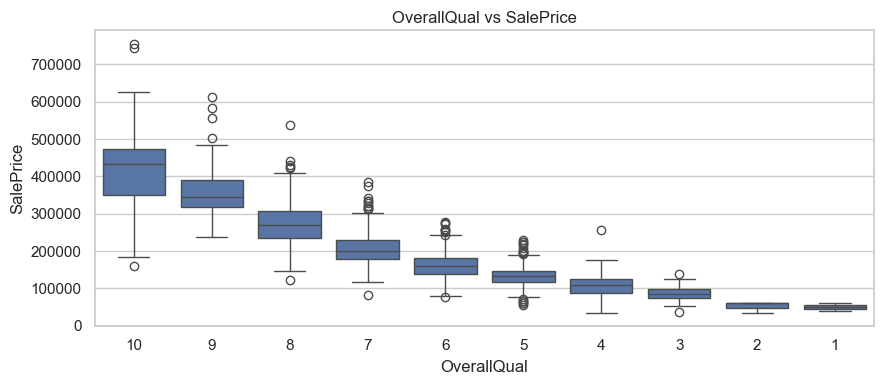

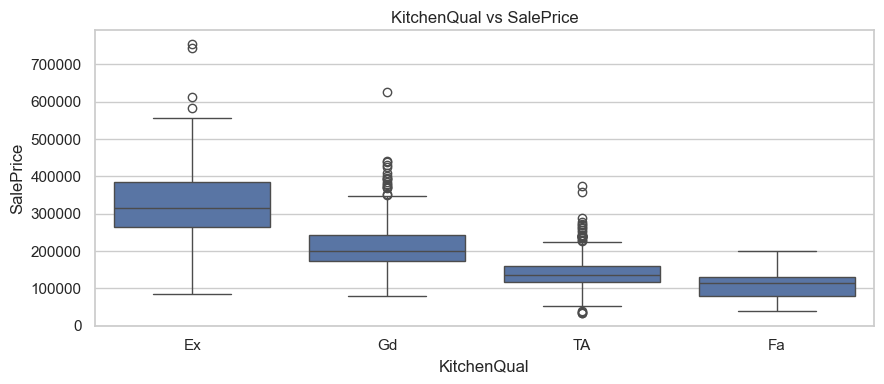

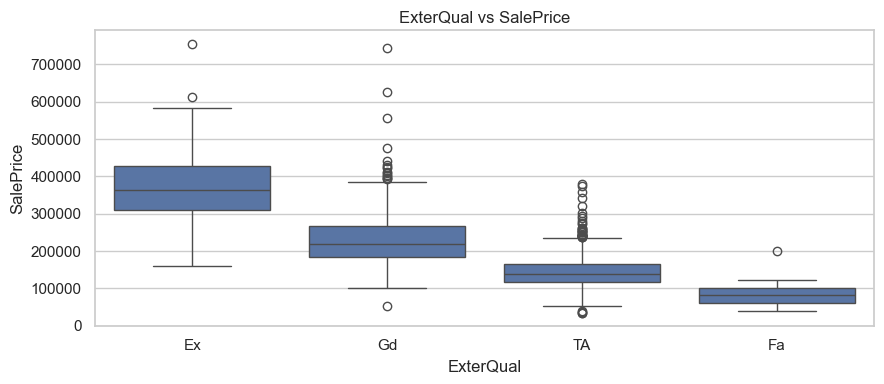

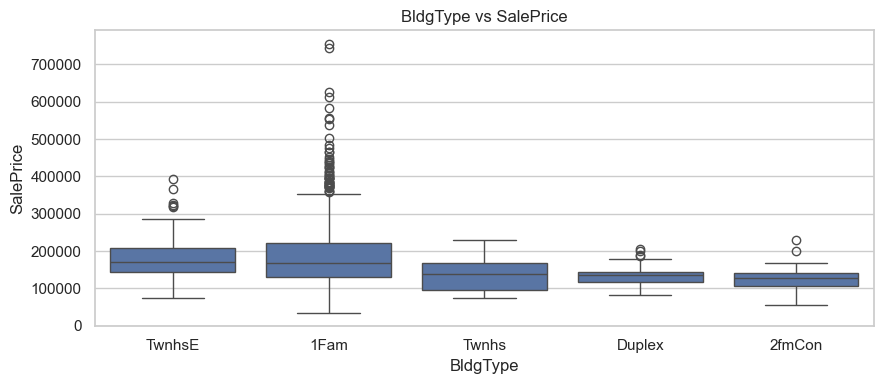

In [31]:
cat_features = ['OverallQual', 'KitchenQual', 'ExterQual', 'BldgType']
for feature in cat_features:
    order = train_df.groupby(feature)[target].median().sort_values(ascending=False).index
    plt.figure(figsize=(9, 4))
    sns.boxplot(data=train_df, x=feature, y=target, order=order)
    plt.title(f"{feature} vs SalePrice")
    plt.tight_layout()
    plt.show()


### Neighborhood effects
Look for location-driven price differences and how they interact with size.


Neighborhood stats (top 5 by median SalePrice):


,median,mean,count
Neighborhood,,,
NridgHt,315000.0,316270.623377,77
NoRidge,301500.0,335295.317073,41
StoneBr,278000.0,310499.000000,25
Timber,228475.0,242247.447368,38
Somerst,225500.0,225379.837209,86


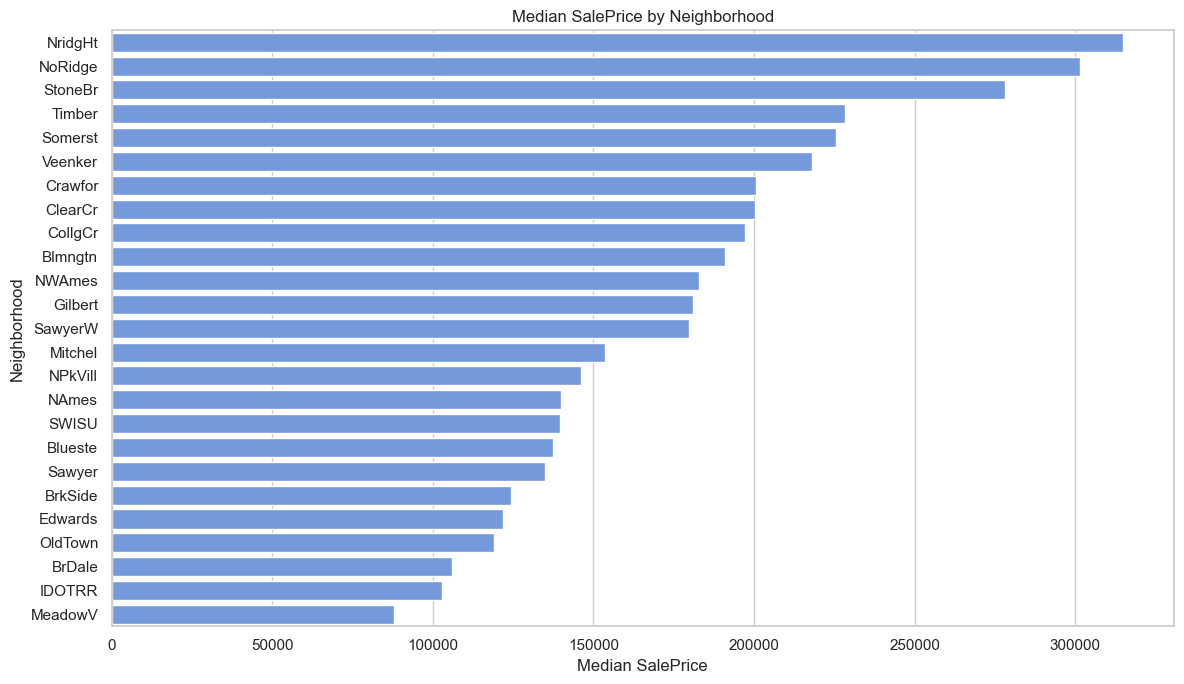

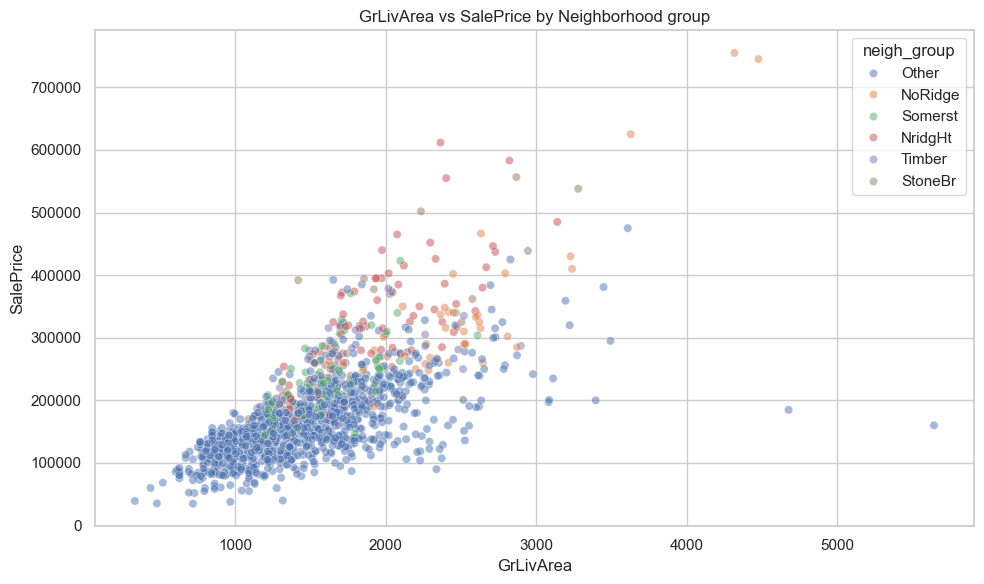

In [32]:
neigh_stats = train_df.groupby('Neighborhood')[target].agg(['median', 'mean', 'count']).sort_values('median', ascending=False)
print('Neighborhood stats (top 5 by median SalePrice):')
display(neigh_stats.head(5))

plt.figure(figsize=(12, 7))
sns.barplot(data=neigh_stats.reset_index(), x='median', y='Neighborhood', color='cornflowerblue')
plt.title('Median SalePrice by Neighborhood')
plt.xlabel('Median SalePrice')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.show()

top_neigh = neigh_stats.head(5).index
scatter_df = train_df.assign(neigh_group=train_df['Neighborhood'].where(train_df['Neighborhood'].isin(top_neigh), 'Other'))
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_df, x='GrLivArea', y=target, hue='neigh_group', alpha=0.5)
plt.title('GrLivArea vs SalePrice by Neighborhood group')
plt.tight_layout()
plt.show()


### Age and renovation signals
Check how build age and remodel recency relate to price.


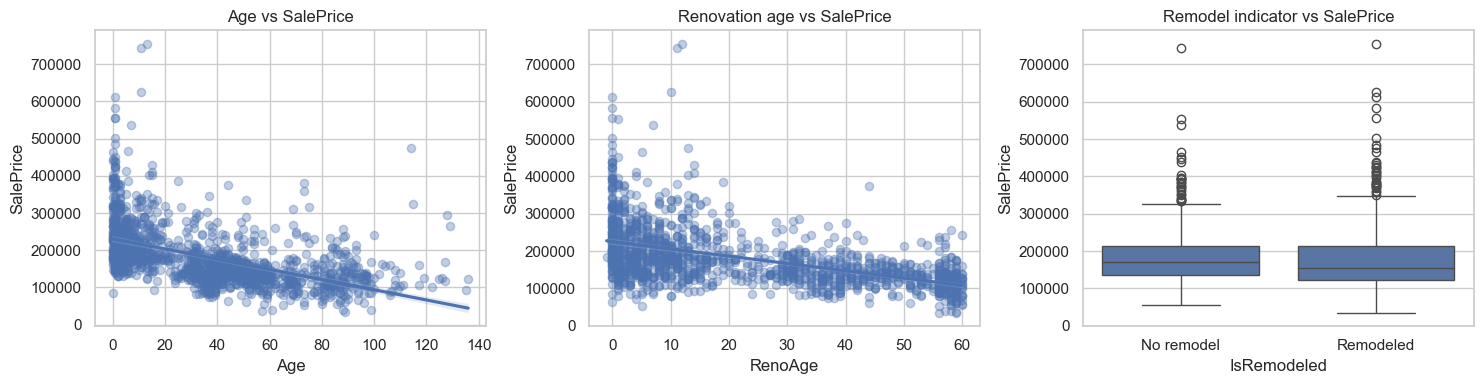

In [33]:
eda_age = train_df.copy()
eda_age['Age'] = eda_age['YrSold'] - eda_age['YearBuilt']
eda_age['RenoAge'] = eda_age['YrSold'] - eda_age['YearRemodAdd']
eda_age['IsRemodeled'] = (eda_age['YearRemodAdd'] != eda_age['YearBuilt']).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.regplot(data=eda_age, x='Age', y=target, ax=axes[0], scatter_kws={'alpha': 0.35, 's': 35})
axes[0].set_title('Age vs SalePrice')

sns.regplot(data=eda_age, x='RenoAge', y=target, ax=axes[1], scatter_kws={'alpha': 0.35, 's': 35})
axes[1].set_title('Renovation age vs SalePrice')

sns.boxplot(data=eda_age, x='IsRemodeled', y=target, ax=axes[2])
axes[2].set_xticklabels(['No remodel', 'Remodeled'])
axes[2].set_title('Remodel indicator vs SalePrice')
plt.tight_layout()
plt.show()


### Area composition & ratios
See how basement/garage proportions relate to price.


,mean,std,min,max
FinishedBsmtRatio,0.448697,0.361698,0.0,1.000000
GarageAreaRatio,0.323993,0.148638,0.0,1.395973
BasementToLiving,0.733998,0.272310,0.0,1.968079


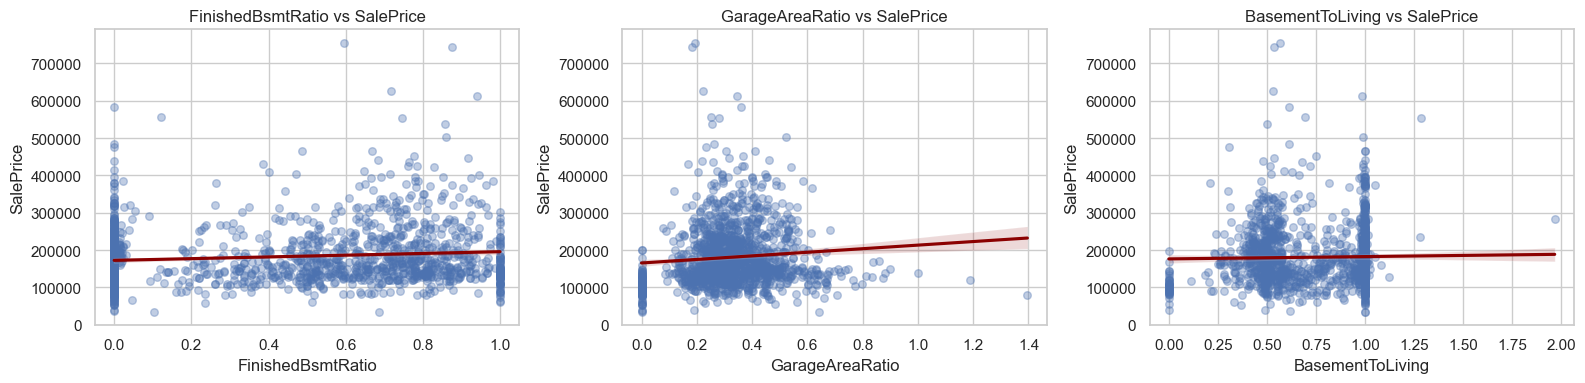

In [34]:
area_df = train_df.copy()
area_df['FinishedBsmtRatio'] = (area_df[['BsmtFinSF1', 'BsmtFinSF2']].sum(axis=1) / area_df['TotalBsmtSF']).replace([np.inf, -np.inf], np.nan)
area_df['GarageAreaRatio'] = area_df['GarageArea'] / area_df['GrLivArea']
area_df['BasementToLiving'] = area_df['TotalBsmtSF'] / area_df['GrLivArea']

ratio_cols = ['FinishedBsmtRatio', 'GarageAreaRatio', 'BasementToLiving']
display(area_df[ratio_cols].describe().T[['mean', 'std', 'min', 'max']])

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, feature in zip(axes, ratio_cols):
    sns.regplot(data=area_df, x=feature, y=target, ax=ax,
                scatter_kws={'alpha': 0.35, 's': 30}, line_kws={'color': 'darkred'})
    ax.set_title(f"{feature} vs SalePrice")
plt.tight_layout()
plt.show()


### Interactions, multicollinearity & outliers
Check correlated predictors, VIFs, interaction strength, and flagged outliers.


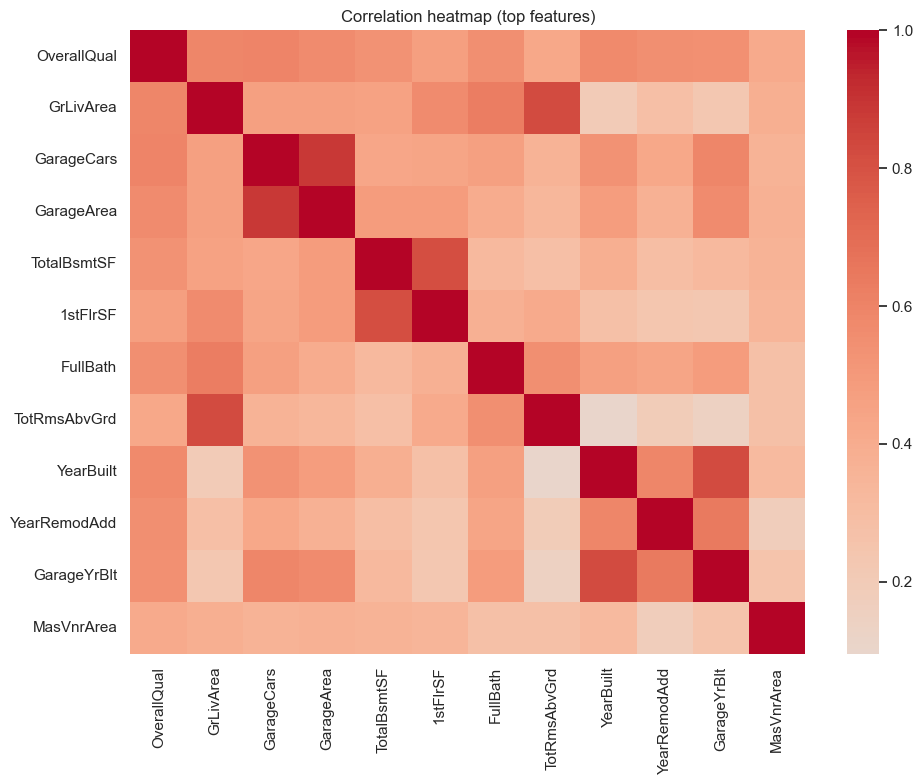

VIF (top correlated features):


,feature,vif
2,GarageCars,5.100492
3,GarageArea,4.929265
1,GrLivArea,4.781486
5,1stFlrSF,3.661984
4,TotalBsmtSF,3.506614
7,TotRmsAbvGrd,3.325444
0,OverallQual,2.293431
6,FullBath,1.897094


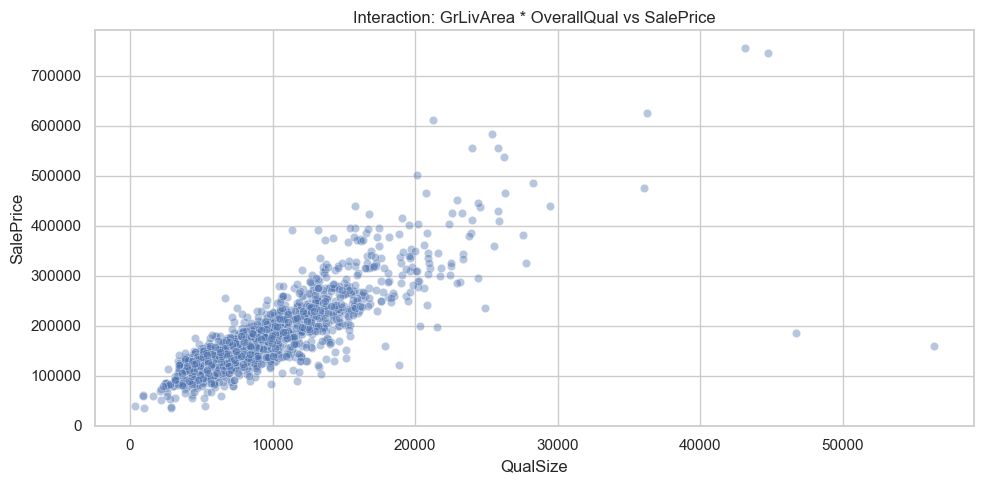

High-leverage candidates (z>3 or GrLivArea>4000): 14


,Id,GrLivArea,SalePrice,Neighborhood
30,31,1317,40000,IDOTRR
440,441,2402,555000,NridgHt
495,496,720,34900,IDOTRR
523,524,4676,184750,Edwards
533,534,334,39300,BrkSide
691,692,4316,755000,NoRidge
803,804,2822,582933,NridgHt
898,899,2364,611657,NridgHt
916,917,480,35311,IDOTRR
968,969,968,37900,OldTown


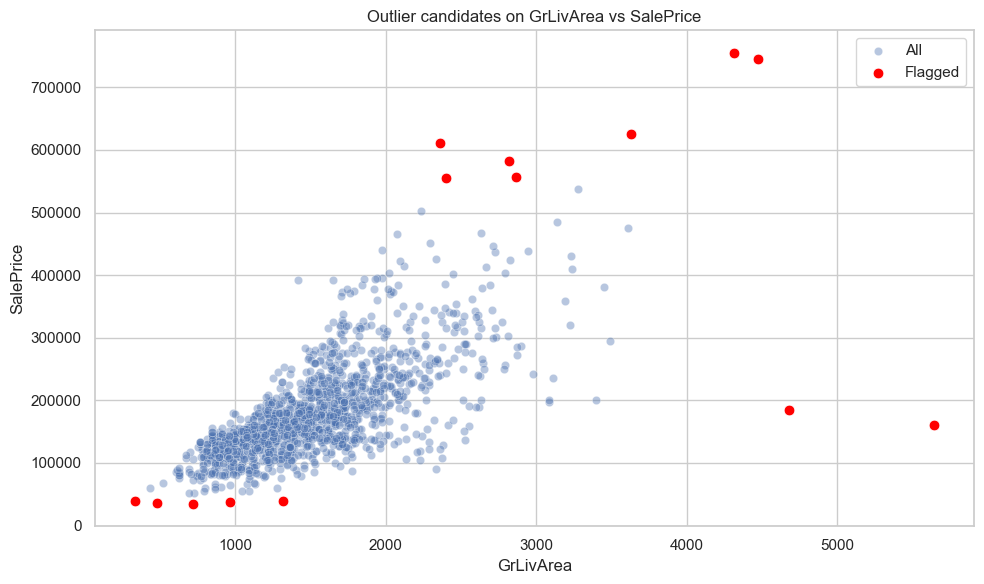

In [35]:
top_corr_features = corr_with_target.abs().head(12).index
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_corr_features].corr(), cmap='coolwarm', center=0)
plt.title('Correlation heatmap (top features)')
plt.tight_layout()
plt.show()


def compute_vif(df, features):
    clean = df[features].dropna().copy()
    clean = (clean - clean.mean()) / clean.std()
    vifs = []
    for feature in features:
        y = clean[feature].values
        X = clean.drop(columns=feature).values
        coef, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        y_pred = X @ coef
        r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - y.mean()) ** 2)
        vif = np.inf if r2 >= 1 else 1 / (1 - r2)
        vifs.append({'feature': feature, 'vif': vif})
    return pd.DataFrame(vifs).sort_values('vif', ascending=False)

vif_df = compute_vif(train_df, corr_with_target.head(8).index.tolist())
print('VIF (top correlated features):')
display(vif_df)

interaction_df = train_df.copy()
interaction_df['QualSize'] = interaction_df['GrLivArea'] * interaction_df['OverallQual']
plt.figure(figsize=(10, 5))
sns.scatterplot(data=interaction_df, x='QualSize', y=target, alpha=0.4)
plt.title('Interaction: GrLivArea * OverallQual vs SalePrice')
plt.tight_layout()
plt.show()

log_price = np.log1p(train_df[target])
price_z = (log_price - log_price.mean()) / log_price.std()
outlier_pts = train_df.loc[(np.abs(price_z) > 3) | (train_df['GrLivArea'] > 4000), ['Id', 'GrLivArea', target, 'Neighborhood']]
print(f"High-leverage candidates (z>3 or GrLivArea>4000): {outlier_pts.shape[0]}")
display(outlier_pts.head(10))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='GrLivArea', y=target, alpha=0.4, label='All')
sns.scatterplot(data=outlier_pts, x='GrLivArea', y=target, color='red', s=60, label='Flagged')
plt.title('Outlier candidates on GrLivArea vs SalePrice')
plt.legend()
plt.tight_layout()
plt.show()


### Temporal patterns
Check for price drift across years and months sold.


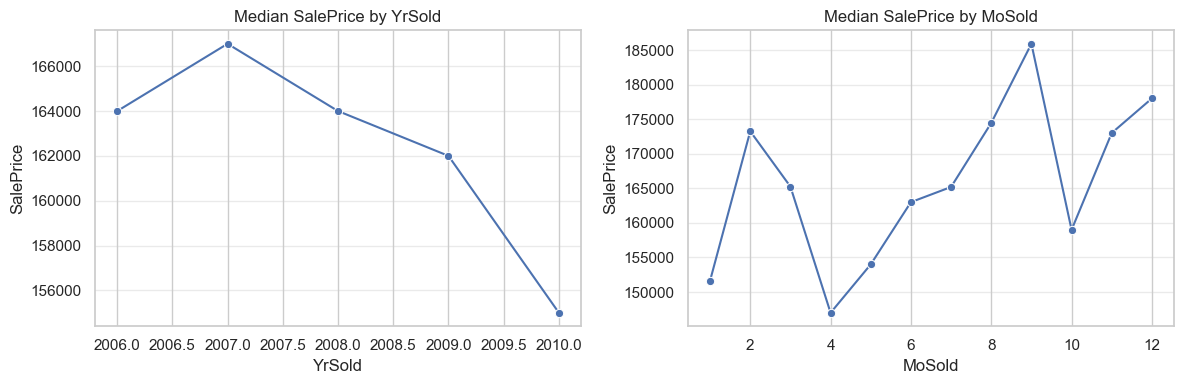

In [36]:
year_trend = train_df.groupby('YrSold')[target].median().reset_index()
month_trend = train_df.groupby('MoSold')[target].median().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=year_trend, x='YrSold', y=target, marker='o', ax=axes[0])
axes[0].set_title('Median SalePrice by YrSold')
axes[0].grid(True, axis='y', alpha=0.4)

sns.lineplot(data=month_trend, x='MoSold', y=target, marker='o', ax=axes[1])
axes[1].set_title('Median SalePrice by MoSold')
axes[1].grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


## 4) Data Preparation

## 5) Data Modelling

## 6) Evaluation

## 7) Conclusion & Submissions